In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Loading, Cleaning and Preprocessing data
##### This project is to predict the price of an airline with given features like duration of flight, route, source, and destination of the flight, the total number of stops, etc.

'Data_Train.xlsx' contains training data with labels (Price) and 'Test_set.xlsx' is an unlabeled testing set
We will just work on 'Data_Train.xlsx'. We will divide the data into three-part training, validation, and testing data. We will train data with the training data, we will tune hyperparameters with validation data, and finally with testing data.



In [2]:
data1 = pd.read_excel('Data_Train.xlsx')

In [3]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [4]:
data1.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [5]:
# we just have one missing value
data1.dropna(inplace= True)

In [6]:
train_len = len(data1)  
data2 = pd.read_excel('Test_set.xlsx')
data= pd.concat([data1, data2], ignore_index= True) 

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13353 entries, 0 to 13352
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          13353 non-null  object 
 1   Date_of_Journey  13353 non-null  object 
 2   Source           13353 non-null  object 
 3   Destination      13353 non-null  object 
 4   Route            13353 non-null  object 
 5   Dep_Time         13353 non-null  object 
 6   Arrival_Time     13353 non-null  object 
 7   Duration         13353 non-null  object 
 8   Total_Stops      13353 non-null  object 
 9   Additional_Info  13353 non-null  object 
 10  Price            10682 non-null  float64
dtypes: float64(1), object(10)
memory usage: 1.1+ MB


In [8]:
data.isnull().sum()

Airline               0
Date_of_Journey       0
Source                0
Destination           0
Route                 0
Dep_Time              0
Arrival_Time          0
Duration              0
Total_Stops           0
Additional_Info       0
Price              2671
dtype: int64

#### Changing date and time columns into pandas datetime object.

In [9]:
# here, I am combining date of journey and departure time in a single columns 

In [10]:
data['Date_Time'] = pd.to_datetime(data['Date_of_Journey']+' '+data['Dep_Time'], dayfirst=True)

In [11]:
# converted duration into pandas time delta format, so that it can be incorporated with 
# datetime object.
data.Duration = pd.to_timedelta(data.Duration)

In [12]:
# Now I can drop Date_of_Journey, and Arrival_Time from the dataframe safely,
# because they are not giving any more informaton that we already have.

# Arrival_Time was also difficult to handle, now, Arrival_Time= Date_Time + duration 

data.drop(['Date_of_Journey', 'Arrival_Time'], axis=1, inplace= True)

In [13]:
 # I have to create day and month columns, because they seems to be important 

In [14]:
data['Day']= data.Date_Time.dt.day
data['Month']= data.Date_Time.dt.month

In [15]:
# Converting departure time into float , by deviding minutes by 60 

In [16]:
data['Dep_Time']=data.Date_Time.dt.hour+data.Date_Time.dt.minute/60

In [17]:
data['Dep_Time']=data.Dep_Time.round(2)

In [18]:
# Converted Duration into total minutes
data.Duration = data.Duration.dt.total_seconds()/60

In [19]:
len(data[data.Date_Time.dt.year!=2019])!=0


False

In [20]:
# all data are from 2019 only so we can also drop Date_Time column

In [21]:
data

,Airline,Source,Destination,Route,Dep_Time,Duration,Total_Stops,Additional_Info,Price,Date_Time,Day,Month
0,IndiGo,Banglore,New Delhi,BLR → DEL,22.33,170.0,non-stop,No info,3897.0,2019-03-24 22:20:00,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,5.83,445.0,2 stops,No info,7662.0,2019-05-01 05:50:00,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,9.42,1140.0,2 stops,No info,13882.0,2019-06-09 09:25:00,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18.08,325.0,1 stop,No info,6218.0,2019-05-12 18:05:00,12,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16.83,285.0,1 stop,No info,13302.0,2019-03-01 16:50:00,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
13348,Air India,Kolkata,Banglore,CCU → DEL → BLR,20.50,1435.0,1 stop,No info,NaN,2019-06-06 20:30:00,6,6
13349,IndiGo,Kolkata,Banglore,CCU → BLR,14.33,155.0,non-stop,No info,NaN,2019-03-27 14:20:00,27,3
13350,Jet Airways,Delhi,Cochin,DEL → BOM → COK,21.83,395.0,1 stop,No info,NaN,2019-03-06 21:50:00,6,3
13351,Air India,Delhi,Cochin,DEL → BOM → COK,4.00,915.0,1 stop,No info,NaN,2019-03-06 04:00:00,6,3


In [22]:
data.drop('Date_Time' ,axis = 1, inplace= True) # now we have no use of it

In [23]:
unique=data.Total_Stops.unique()
unique

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [24]:
data.Total_Stops = data.Total_Stops.replace(unique,[0,2,1,3,4])

In [25]:
data.Source.unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

In [26]:
data.Destination.unique() # delhi is twice

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

In [27]:
data.Airline.unique() 

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

In [28]:
data.Destination=data.Destination.replace('New Delhi','Delhi') # making new delhi, delhi

In [29]:
data.columns.values

array(['Airline', 'Source', 'Destination', 'Route', 'Dep_Time',
       'Duration', 'Total_Stops', 'Additional_Info', 'Price', 'Day',
       'Month'], dtype=object)

In [30]:
# Here none of the values can be wrong , all the right data, so we can not remove data.

In [31]:
# data.Price[data.Price>40000]= data.Price.median() # replacing outlliers with median

In [32]:
data.Additional_Info.unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

### Exploratory data analysis and feature elimination

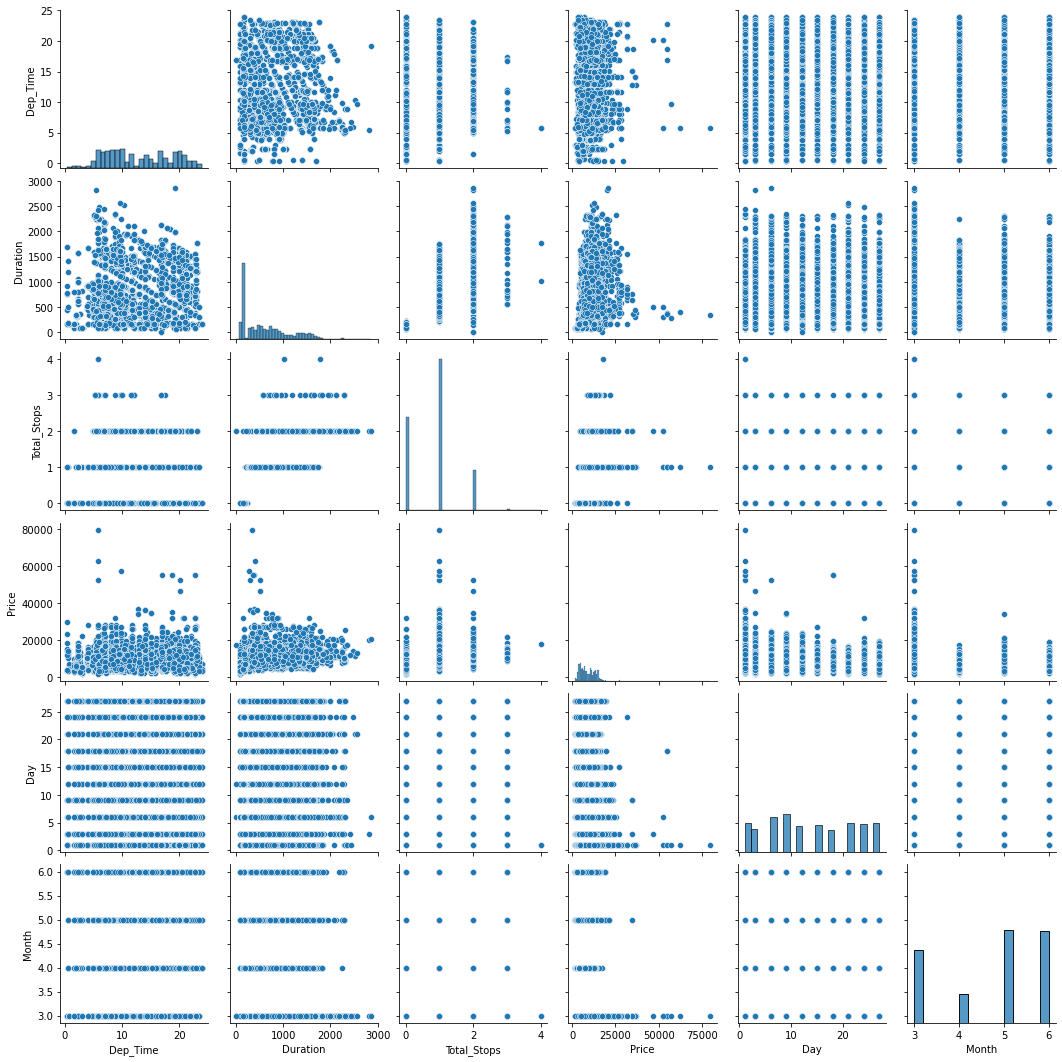

In [33]:
sns.pairplot(data)

In [34]:
# sns.catplot(x="Duration", y="Price", hue='Total_Stops', data=data, kind= 'strip')


<AxesSubplot:xlabel='Day', ylabel='Price'>

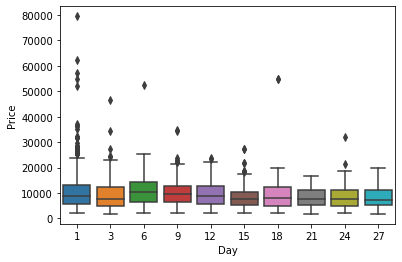

In [35]:
sns.boxplot(data=data,x="Day", y="Price")

<AxesSubplot:xlabel='Month', ylabel='Price'>

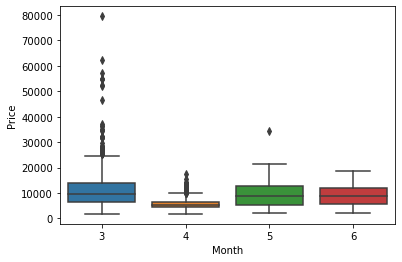

In [36]:
sns.boxplot(data=data,x="Month", y="Price")

<AxesSubplot:xlabel='Duration', ylabel='Price'>

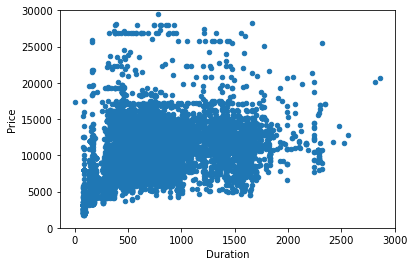

In [37]:
data.plot.scatter(x="Duration", y="Price", ylim=(0,30000))

<AxesSubplot:xlabel='Route', ylabel='Price'>

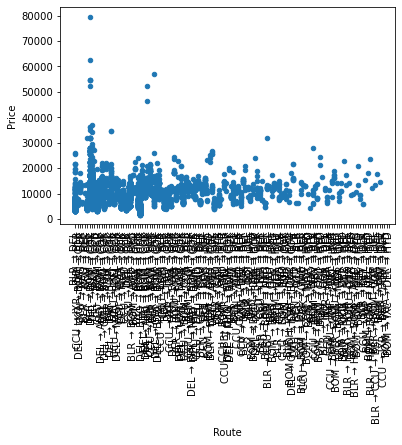

In [38]:
data.plot.scatter(x="Route", y="Price",rot=90)

Route column is not providing anymore information then the tota stops and duration.
It is also not significantly correlated to the price. We can drop this columns.

<AxesSubplot:xlabel='Airline', ylabel='Price'>

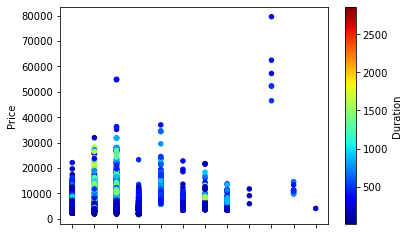

In [39]:
data.plot.scatter(x="Airline", y="Price",c= 'Duration',colormap= 'jet', rot= 90) 

In [40]:
# checking spearman correlation for all columns. Data are not Gaussian at all 

data.corr(method = 'spearman')

,Dep_Time,Duration,Total_Stops,Price,Day,Month
Dep_Time,1.000000,-0.020421,-0.070352,0.003320,-0.003546,0.027194
Duration,-0.020421,1.000000,0.822642,0.692579,-0.024014,0.029136
Total_Stops,-0.070352,0.822642,1.000000,0.715551,-0.012043,0.055413
Price,0.003320,0.692579,0.715551,1.000000,-0.121830,-0.039704
Day,-0.003546,-0.024014,-0.012043,-0.121830,1.000000,-0.041269
Month,0.027194,0.029136,0.055413,-0.039704,-0.041269,1.000000


In [41]:
from scipy.stats import pearsonr, spearmanr


rho = data.corr(method='spearman')
pval = data.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['**' for t in [0.01] if x<=t]))
rho.round(4).astype(str) + p

,Dep_Time,Duration,Total_Stops,Price,Day,Month
Dep_Time,1.0**,-0.0204,-0.0704**,0.0033,-0.0035,0.0272**
Duration,-0.0204,1.0**,0.8226**,0.6926**,-0.024**,0.0291**
Total_Stops,-0.0704**,0.8226**,1.0**,0.7156**,-0.012,0.0554**
Price,0.0033,0.6926**,0.7156**,1.0**,-0.1218**,-0.0397**
Day,-0.0035,-0.024**,-0.012,-0.1218**,1.0**,-0.0413**
Month,0.0272**,0.0291**,0.0554**,-0.0397**,-0.0413**,1.0**


#### From the above table, we observe the followings
1. Price is not correlated with Day, Month, and Departure time 
2. Uncorrelation of Day and Month are statistically significant but, Departure time is not significant p>0.01 
3. We can drop day and month columns but can not drop dep time 
4. Total stops are correlated with the duration with a significance of p<0.01, but that is 0.7, so we do not drop it.

In [42]:
rho = data.corr()
pval = data.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['**' for t in [0.01] if x<=t]))
rho.round(4).astype(str) + p

,Dep_Time,Duration,Total_Stops,Price,Day,Month
Dep_Time,1.0**,-0.0029,-0.0707**,0.0055,-0.0035,0.0307**
Duration,-0.0029,1.0**,0.7369**,0.5065**,-0.0228**,0.0083
Total_Stops,-0.0707**,0.7369**,1.0**,0.6039**,-0.0111,0.0469**
Price,0.0055,0.5065**,0.6039**,1.0**,-0.1538**,-0.1036**
Day,-0.0035,-0.0228**,-0.0111,-0.1538**,1.0**,-0.0355**
Month,0.0307**,0.0083,0.0469**,-0.1036**,-0.0355**,1.0**


In [43]:
data.Month.unique()

array([3, 5, 6, 4], dtype=int64)

In [44]:
data.Day.unique()

array([24,  1,  9, 12, 27, 18,  3, 15,  6, 21], dtype=int64)

In [45]:
#data.drop(['Day','Month', 'Route'], axis= 1, inplace= True)
data.drop([ 'Route'], axis= 1, inplace= True)

#### Perfoming one hot encoding to all categorical columns

In [46]:
data_processed = pd.get_dummies(data,prefix= None)

In [47]:
data_processed.columns.values

array(['Dep_Time', 'Duration', 'Total_Stops', 'Price', 'Day', 'Month',
       'Airline_Air Asia', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways',
       'Airline_Jet Airways Business', 'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara',
       'Airline_Vistara Premium economy', 'Source_Banglore',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata',
       'Source_Mumbai', 'Destination_Banglore', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Additional_Info_1 Long layover',
       'Additional_Info_1 Short layover',
       'Additional_Info_2 Long layover', 'Additional_Info_Business class',
       'Additional_Info_Change airports',
       'Additional_Info_In-flight meal not included',
       'Additional_Info_No Info',
       'Additional_Info_No check-in baggage included',
       'Additional_Info

In [48]:
list_drop=['Additional_Info_No Info','Additional_Info_No info','Additional_Info_1 Short layover'
           ,'Additional_Info_1 Long layover','Additional_Info_2 Long layover'
           ,'Additional_Info_Change airports']

# these columns are not giving us any info other then number of stops and time duration

In [49]:
data_processed.drop(list_drop, axis=1, inplace= True)

In [50]:
data_processed.columns.values

array(['Dep_Time', 'Duration', 'Total_Stops', 'Price', 'Day', 'Month',
       'Airline_Air Asia', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways',
       'Airline_Jet Airways Business', 'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara',
       'Airline_Vistara Premium economy', 'Source_Banglore',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata',
       'Source_Mumbai', 'Destination_Banglore', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Additional_Info_Business class',
       'Additional_Info_In-flight meal not included',
       'Additional_Info_No check-in baggage included',
       'Additional_Info_Red-eye flight'], dtype=object)

In [51]:
# now we devide test and train data set
df=data_processed.copy()  # we want to keep data_processed

In [52]:
final_test = df.iloc[train_len:]

In [57]:
df

,Dep_Time,Duration,Total_Stops,Price,Day,Month,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,...,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Additional_Info_Business class,Additional_Info_In-flight meal not included,Additional_Info_No check-in baggage included,Additional_Info_Red-eye flight
0,22.33,170.0,0,3897.0,24,3,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,5.83,445.0,2,7662.0,1,5,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,9.42,1140.0,2,13882.0,9,6,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,18.08,325.0,1,6218.0,12,5,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,16.83,285.0,1,13302.0,1,3,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13348,20.50,1435.0,1,NaN,6,6,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
13349,14.33,155.0,0,NaN,27,3,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
13350,21.83,395.0,1,NaN,6,3,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
13351,4.00,915.0,1,NaN,6,3,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [58]:
X= df.iloc[:train_len,df.columns.values!="Price"].values
y= df.iloc[:train_len,df.columns.values=="Price"].values

 ### Exploring models and hyperparameter tuning
 
 We will try diffrent algorithms for better accuracy and tune some other hyperparamenters.

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

y= y.ravel()

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=18)

In [60]:
len(X_train),len(X_val), len(X_test)

(6408, 2137, 2137)

### Trying linear models

In [61]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score

In [62]:
degree = [2,3]
alpha=[0.06,0.1,0.3,1]
penalty= ["l1",'l2']  # l1 is lasso and l2 is ridge


In [63]:
# Create the random grid
reg_model = Pipeline([('poly',PolynomialFeatures(degree=3)),("scale",MinMaxScaler()),("reg",SGDRegressor())])
random_grid={ 
     'poly__degree':degree,
    'reg__alpha' :alpha,
    'reg__penalty': penalty}

In [64]:
#GridSearchCV?

In [292]:
reg_model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'poly', 'scale', 'reg', 'poly__degree', 'poly__include_bias', 'poly__interaction_only', 'poly__order', 'scale__clip', 'scale__copy', 'scale__feature_range', 'reg__alpha', 'reg__average', 'reg__early_stopping', 'reg__epsilon', 'reg__eta0', 'reg__fit_intercept', 'reg__l1_ratio', 'reg__learning_rate', 'reg__loss', 'reg__max_iter', 'reg__n_iter_no_change', 'reg__penalty', 'reg__power_t', 'reg__random_state', 'reg__shuffle', 'reg__tol', 'reg__validation_fraction', 'reg__verbose', 'reg__warm_start'])

In [293]:
# Random search of parameters, using 3 fold cross validation
reg_best = GridSearchCV(estimator=reg_model ,param_grid=random_grid,cv=10)

In [294]:
reg_best.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                                       ('scale', MinMaxScaler()),
                                       ('reg', SGDRegressor())]),
             param_grid={'reg__alpha': [0.06, 0.1, 0.3, 1],
                         'reg__penalty': ['l1', 'l2']})

In [370]:
reg_best.best_estimator_

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('scale', MinMaxScaler()),
                ('reg', SGDRegressor(alpha=0.06, penalty='l1'))])

In [ ]:
# we used above meters in new model 

In [364]:
# reg_best.score(X_train,y_train), reg_model.score(X_val,y_val)

In [365]:
r2_score (reg_best.predict(X_val), y_val)

0.7485896811885234

In [366]:
r2_score (reg_best.predict(X_train), y_train)

0.7222518116006158

In [367]:
coef_best = reg_best.best_estimator_.named_steps['reg'].coef_

In [368]:
len(coef_best)

5984

In [369]:
len(coef_best[np.where(coef_best!=0)])

1498

In [65]:
reg_model = Pipeline([('poly',PolynomialFeatures(degree=3)),("scale",MinMaxScaler()),("reg",SGDRegressor(alpha=0.06,penalty="l1"))])

In [66]:
reg_model.fit(X_train,y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('scale', MinMaxScaler()),
                ('reg', SGDRegressor(alpha=0.06, penalty='l1'))])

In [67]:
reg_model.score(X_train,y_train), reg_model.score(X_val,y_val), reg_model.score(X_train,y_train)

(0.7949716749032788, 0.8231365592124216, 0.7949716749032788)

In [68]:
# above is the best score we got from linear models 

In [72]:
X_train1, X_test1, y_train1, y_test1  = train_test_split(X, y, test_size=0.2, random_state=18)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=18)

In [73]:
reg_model.fit(X_train1,y_train1)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('scale', MinMaxScaler()),
                ('reg', SGDRegressor(alpha=0.06, penalty='l1'))])

In [78]:
reg_model.score(X_train1,y_train1), reg_model.score(X_test1, y_test1)

(0.7947970093907295, 0.8080269482754462)

### Trying nonlinear models 

In [432]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [434]:
model = DecisionTreeRegressor(max_depth=16,min_samples_leaf=50)


In [435]:
model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=16, min_samples_leaf=50)

In [436]:
# seeing which parameters are more important 

model.feature_importances_

array([4.69775930e-03, 5.84213082e-01, 2.95350909e-02, 7.61372646e-02,
       6.97164782e-02, 7.46423276e-05, 4.29634371e-03, 0.00000000e+00,
       3.24106577e-03, 6.75902802e-02, 0.00000000e+00, 2.04256529e-02,
       0.00000000e+00, 6.04078352e-04, 0.00000000e+00, 2.78773738e-03,
       0.00000000e+00, 2.02457298e-03, 9.94939347e-05, 3.34998763e-03,
       2.17023124e-03, 0.00000000e+00, 1.91469536e-04, 0.00000000e+00,
       2.48915896e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.03953180e-01, 0.00000000e+00, 0.00000000e+00])

In [ ]:
df.iloc[train_len:,df.columns.values!="Price"]


In [486]:
cols=df.columns[df.columns.values!="Price"]

In [487]:
col=pd.DataFrame([cols,model.feature_importances_]).T
col

,0,1
0,Dep_Time,0.004698
1,Duration,0.584213
2,Total_Stops,0.029535
3,Day,0.076137
4,Month,0.069716
5,Airline_Air Asia,0.000075
6,Airline_Air India,0.004296
7,Airline_GoAir,0.0
8,Airline_IndiGo,0.003241
9,Airline_Jet Airways,0.06759


In [443]:
col.sort_values(by=1, ascending=False)

,0,1
1,Duration,0.584213
28,Additional_Info_Business class,0.103953
3,Price,0.076137
4,Day,0.069716
9,Airline_IndiGo,0.06759
2,Total_Stops,0.029535
24,Destination_Cochin,0.024892
11,Airline_Jet Airways Business,0.020426
0,Dep_Time,0.004698
6,Airline_Air Asia,0.004296


In [444]:
model.score(X_train,y_train),model.score(X_val,y_val)  # checking r2 scores

(0.7276689286676239, 0.7055943006759443)

In [445]:
model = RandomForestRegressor(max_depth=6)
model.fit(X_train,y_train)

RandomForestRegressor(max_depth=6)

In [446]:
model.score(X_train,y_train),model.score(X_val,y_val)

(0.8126388008655575, 0.8238528291089339)

In [448]:
# Checking the best random sampling for training se
for i in range(20):
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=i)
    model = RandomForestRegressor(n_estimators=5,max_depth=10)
    model.fit(X_train,y_train)
    if (model.score(X_train,y_train)<model.score(X_val,y_val)):
        print(i, model.score(X_train,y_train),model.score(X_val,y_val))

In [449]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=18)
model = RandomForestRegressor(n_estimators=15,max_depth=7)
model.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, n_estimators=15)

In [450]:
model.score(X_train,y_train),model.score(X_val,y_val)

(0.850544387396594, 0.8481808400809353)

In [482]:
model.predict(final_test.iloc[:,df.columns.values!="Price"].values)
data_o_test=df.iloc[train_len:,df.columns.values!="Price"]

In [483]:
data_o_test['Price_predicted']=model.predict(final_test.iloc[:,df.columns.values!="Price"].values)

In [484]:
# to just eyeball how the model is predicting 
data_o_test[data_o_test['Additional_Info_Business class']==1]

,Dep_Time,Duration,Total_Stops,Day,Month,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,...,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Additional_Info_Business class,Additional_Info_In-flight meal not included,Additional_Info_No check-in baggage included,Additional_Info_Red-eye flight,Price_predicted
12484,5.75,450.0,1,1,3,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,15604.464646


In [454]:
from sklearn import metrics

def predict(ml_model,dump=0):
    
    model=ml_model.fit(X_train,y_train)
    print('Training score : {}'.format(model.score(X_train,y_train)))
    y_prediction=model.predict(X_val)
    print('predictions are: \n {}'.format(y_prediction))
    print('\n')
    r2_score=metrics.r2_score(y_val,y_prediction)
    print('r2 score: {}'.format(r2_score))
    print('MAE:',metrics.mean_absolute_error(y_val,y_prediction))
    print('MSE:',metrics.mean_squared_error(y_val,y_prediction))
    print('RMSE:',np.sqrt(metrics.mean_squared_error(y_val,y_prediction)))
    sns.distplot(y_val-y_prediction)
    
    if dump==1:
        ##dump your model using pickle so that we will re-use
        file=open('E:\End-2-end Projects\Flight_Price/model.pkl','wb')
        pickle.dump(model,file)

In [455]:
model = RandomForestRegressor(n_estimators=15,max_depth=16, min_samples_leaf=30)

Training score : 0.7546102475214826
predictions are: 
 [ 7491.1784943  14022.20911945  3893.55839932 ... 10993.37495849
  9736.29011653 14096.69867928]


r2 score: 0.7398999049829867
MAE: 1250.798062807658
MSE: 5754972.119291534
RMSE: 2398.9522961683783


C:\Users\shris\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


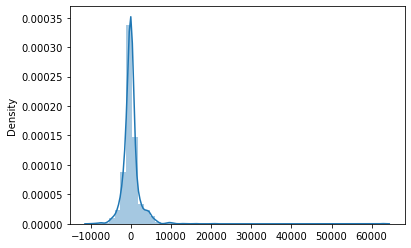

In [456]:
predict(model)

Training score : 0.7276689286676239
predictions are: 
 [ 7154.58163265 14292.67307692  3812.83018868 ... 11351.93589744
  9302.40909091 14304.17333333]


r2 score: 0.7055943006759443
MAE: 1339.9130243869165
MSE: 6514017.579500086
RMSE: 2552.2573497788358


C:\Users\shris\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


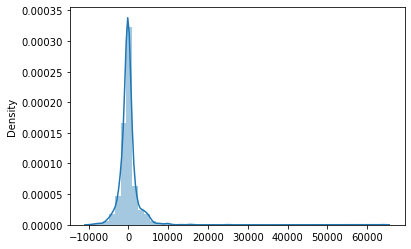

In [458]:
model = DecisionTreeRegressor(max_depth=16,min_samples_leaf=50)
predict(model)

### RandomSearchCV for random forest 

In [75]:
# Number of trees in random forest
n_estimators=[int(x) for x in np.linspace(start=100,stop=1200,num=6)]

# Number of features to consider at every split
max_features=['auto','sqrt']

# Maximum number of levels in tree
max_depth=[int(x) for x in np.linspace(5,30,num=4)]

# Minimum number of samples required to split a node
min_samples_split=[5,10,15,100]

In [463]:
# Create the random grid

random_grid={
    'n_estimators':n_estimators,
    'max_features':max_features,
'max_depth':max_depth,
    'min_samples_split':min_samples_split
}

In [464]:
### initialise your estimator
reg_rf=RandomForestRegressor()

In [465]:
# Random search of parameters, using 3 fold cross validation

rf_random=RandomizedSearchCV(estimator=reg_rf,param_distributions=random_grid,cv=5,verbose=2,n_jobs=-1)

In [466]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 13, 21, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10, 15, 100],
                                        'n_estimators': [100, 320, 540, 760,
                                                         980, 1200]},
                   verbose=2)

In [467]:
rf_random.best_params_

{'n_estimators': 980,
 'min_samples_split': 5,
 'max_features': 'auto',
 'max_depth': 30}

In [468]:
prediction=rf_random.predict(X_val)

C:\Users\shris\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

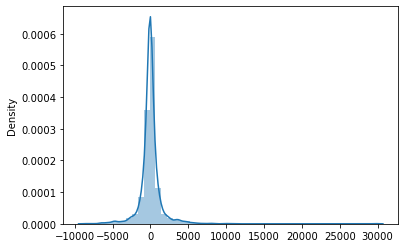

In [469]:
sns.distplot(y_val-prediction)

In [477]:
metrics.r2_score(y_val,prediction)

-0.793776103707815

In [478]:
print('MAE',metrics.mean_absolute_error(y_test,prediction))
print('MSE',metrics.mean_squared_error(y_test,prediction))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_test,prediction)))

MAE 770.0131807882253
MSE 2487532.1282594977
RMSE 1577.191214868856


In [479]:
rf_random.score(X_val,y_val)

0.8987944301503203

In [480]:
rf_random.score(X_test,y_test)

0.8787202147448584

In [481]:
prediction=rf_random.predict(X_test)

In [475]:
metrics.r2_score(y_test,prediction)  # this is best with non linear models 

0.8787202147448584